<a href="https://colab.research.google.com/github/lgvaz/mantisshrimp/blob/master/notebooks/custom_parsers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Parsers

In [1]:
from mantisshrimp.imports import *
from mantisshrimp import *
import pandas as pd

## Understand the data format

In this task we were given a `.csv` file with annotations, let's take a look at that.

<div class="alert alert-info">
    
**Note:**  

Replace `source` with your own path for the dataset directory.
    
</div>

In [2]:
source = Path("/home/lgvaz/.data/wheat")
df = pd.read_csv(source / "train.csv")
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


At first glance, we can make the following assumptions:  
* Multiple rows with the same object_id, width, height  
* A different bbox for each row  
* source doesn't seem relevant right now  
Once we know what our data provides we can create our custom `Parser`.  

## Create the Parser

When creating a `Parser` we inherit from smaller building blocks that provides the functionallity we want:  
* `DefaultImageInfoParser`: Will parse standard fields for image information, e.g. `filepath`, `height`, `width`  
* `FasterRCNNParser`: Since we only need to predict bboxes we will use a `FasterRCNN` model, this will parse all the requirements for using such a model.  

We can also specify exactly what fields we would like to parse, in fact, the parsers we are currently using are just helper classes that groups a collection of individual parsers.  
We are going to see how to use individual parsers in a future tutorial.

<div class="alert alert-info">
    
**Note:**

If you are using an IDE there is a little bit of magic than can happen. Once you created defined your class you can right click on it and select the option _"implement abstract methods"_, this will automatically populate your class with all the methods you need to override. 

If you are using a notebook, or your IDE does not support that, check the documentation to know what methods you should override.

</div>


<div class="alert alert-warning">
    
**Important:**  
    
Be sure to return the correct type on all overriden methods!
    
</div>

In [3]:
class WheatParser(DefaultImageInfoParser, FasterRCNNParser):
    def __init__(self, df, source):
        self.df = df
        self.source = source
        self.imageid_map = IDMap()

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> int:
        return self.imageid_map[o.image_id]

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}.jpg"

    def height(self, o) -> int:
        return o.height

    def width(self, o) -> int:
        return o.width

    def labels(self, o) -> List[int]:
        return [1]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=","))]

Defining the `__init__` is completely up to you, normally we have to pass our data (the `df` in our case) and the folder where our images are contained (`source` in our case).

We then override `__iter__`, telling our parser how to iterate over our data. In our case we call `df.itertuples` to iterate over all `df` rows.

`__len__` is not obligatory but will help visualizing the progress when parsing.

And finally we override all the other methods, they all receive a single argument `o`, which is the object returned by `__iter__`.

Now we just need to decide how to split our data and `Parser.parse`!

In [4]:
data_splitter = RandomSplitter([.8, .2])
parser = WheatParser(df, source / "train")
train_rs, valid_rs = parser.parse(data_splitter)

Let's take a look at one record.

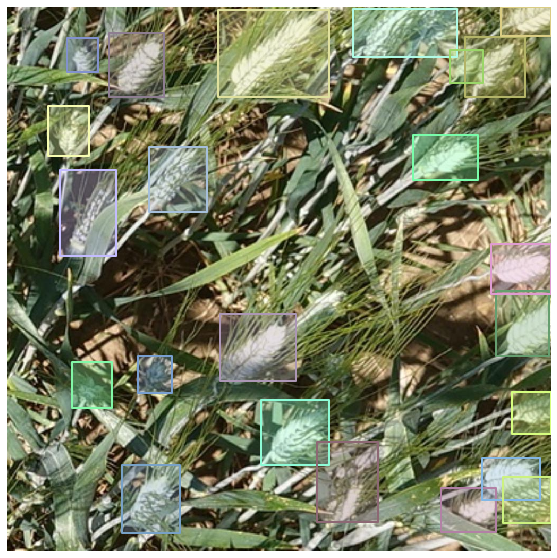

In [5]:
show_record(train_rs[0], label=False)

## Conclusion

And that's it! Now that you have your data in the standard library record format, you can use it to create a `Dataset`, visualize the image with the annotations and basically use all helper functions that Mantisshrimp provides! 